In [16]:
# Imports
from functions import kernel_smoothing, kernel_derivatives, plot_comparison, functional_form_PDE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing

In [17]:
# Data and Preprocessing
# u = np.load("data/bg.npy")
# u = np.load("data/diff.npy")
u = np.load("data/ks.npy")
u = np.squeeze(u)
fx = np.cos(2 * np.pi * np.linspace(0, 100, 1024))
x = np.linspace(0, 100, 1024)
m, n = u.shape
u = sklearn.preprocessing.normalize(u)

In [18]:
# Noise
u_noisy = u + np.random.normal(scale=0.02, size=(m, n))

In [19]:
l_values = [0.01, 0.1, 1, 5, 10]
c_values = [0.25, 0.5, 1, 5]
d_values = [1, 2, 3, 4, 5]
gamma_values = [0.0001, 0.001, 0.01]

Best lengthscale value for smoothing: 1.0


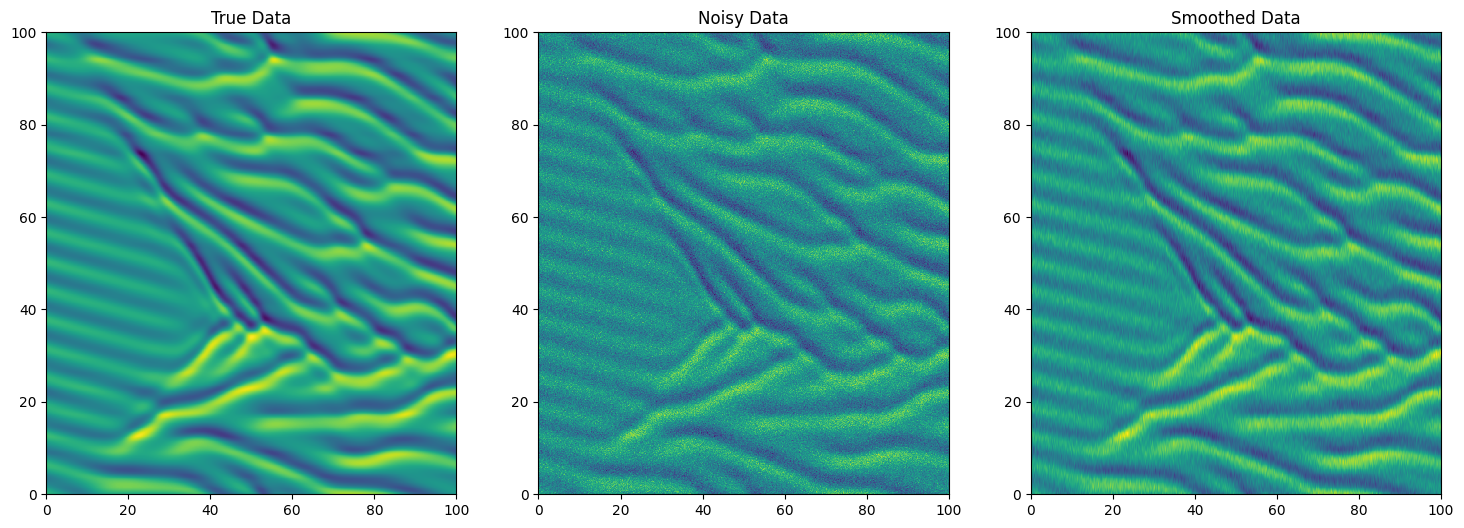

In [20]:
# RBF
U_mse_rbf = []
for l in l_values:
    kwargs = {'l': l}
    u_smooth = kernel_smoothing(u_noisy, x, kernel='rbf', **kwargs)
    mse = mean_squared_error(u, u_smooth)
    U_mse_rbf.append(mse)
    
U_rbf_data = pd.DataFrame(columns=(['l_value', 'mse']))
U_rbf_data['l_value'] = l_values
U_rbf_data['mse'] = U_mse_rbf

U_rbf_min_index = U_rbf_data['mse'].idxmin()
U_best_l = U_rbf_data.loc[U_rbf_min_index, 'l_value']
print(f"Best lengthscale value for smoothing: {U_best_l}")

U_best_rbf = {'l': U_best_l}
u_smooth_rbf = kernel_smoothing(u_noisy, x, kernel='rbf', **U_best_rbf)
plot_comparison(x, t=x, u=u, u_noisy=u_noisy, u_smooth=u_smooth_rbf)

Best coef0 value: 1.0
Best degree value: 5
Best gamma value: 0.01


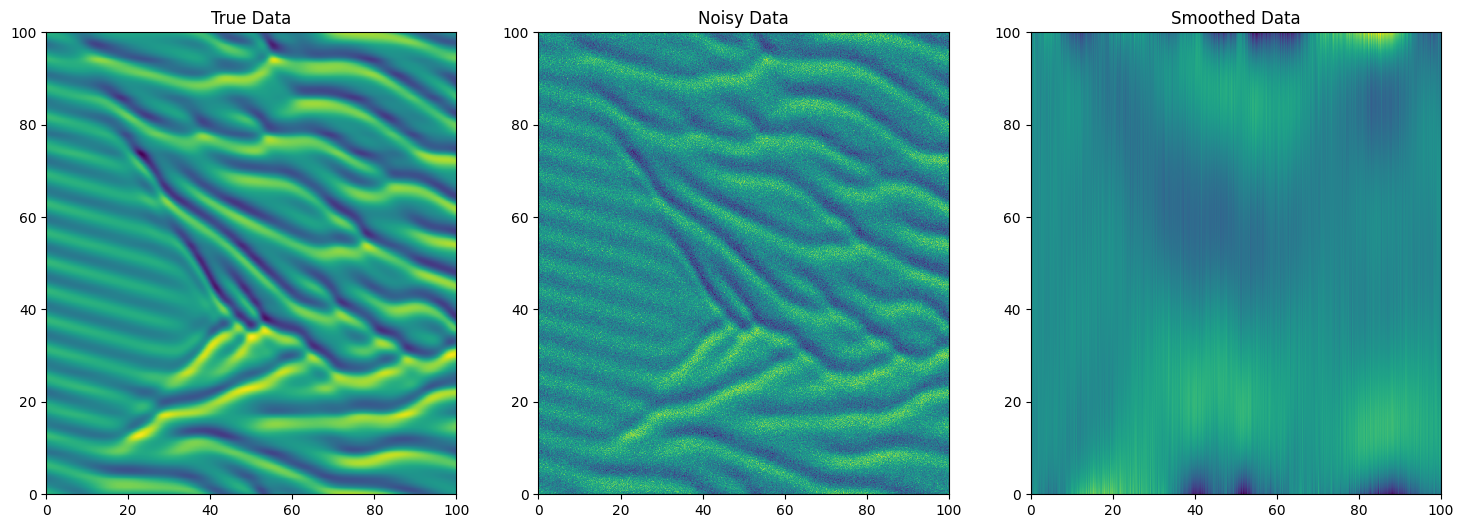

In [21]:
# Polynomial
U_mse_poly = []
U_combinations_poly = []
for gamma in gamma_values:
    for c in c_values:
        for d in d_values:
            kwargs = {'coef0': c, 'degree': d, 'gamma': gamma}
            u_smooth = kernel_smoothing(u_noisy, x, kernel='poly', **kwargs)
            mse = mean_squared_error(u, u_smooth)
            U_mse_poly.append(mse)
            U_combinations_poly.append((c, d, gamma))

U_poly_data = pd.DataFrame(U_combinations_poly, columns=['c_value', 'd_value', 'gamma_value'])
U_poly_data['mse'] = U_mse_poly

U_poly_min_index = U_poly_data['mse'].idxmin()
U_best_c = U_poly_data.loc[U_poly_min_index, 'c_value']
U_best_d = U_poly_data.loc[U_poly_min_index, 'd_value']
U_best_gamma = U_poly_data.loc[U_poly_min_index, 'gamma_value']
print(f"Best coef0 value: {U_best_c}")
print(f"Best degree value: {U_best_d}")
print(f"Best gamma value: {U_best_gamma}")

U_best_poly = {'coef0': U_best_c, 'degree': U_best_d, 'gamma': U_best_gamma}
u_smooth_poly = kernel_smoothing(u_noisy, x, kernel='poly', **U_best_poly)
plot_comparison(x, t=x, u=u, u_noisy=u_noisy, u_smooth=u_smooth_poly)

Best coef0 value: 0.5
Best gamma value: 0.5


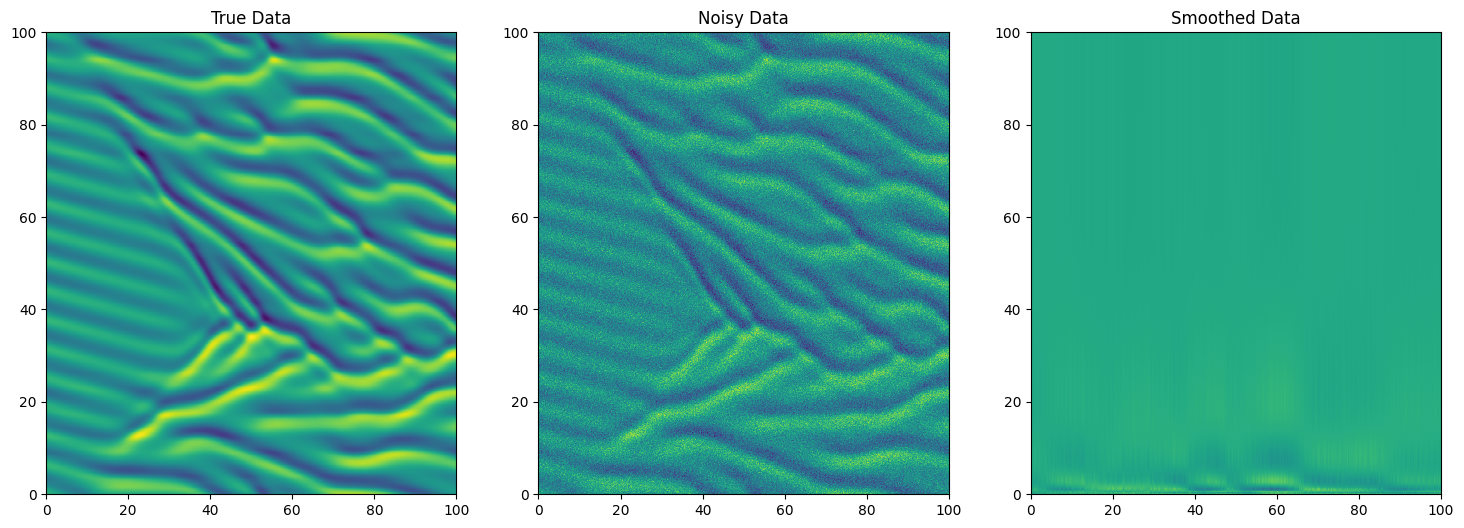

In [22]:
# Sigmoid
U_mse_sigmoid = []
U_combinations_sigmoid = []
for gamma in gamma_values:
    for c in c_values:
        kwargs = {'coef0': c, 'gamma': gamma}
        u_smooth = kernel_smoothing(u_noisy, x, kernel='sigmoid', **kwargs)
        mse = mean_squared_error(u, u_smooth)
        U_mse_sigmoid.append(mse)
        U_combinations_sigmoid.append((c, gamma))

U_sigmoid_data = pd.DataFrame(U_combinations_sigmoid, columns=['c_value', 'gamma_value'])
U_sigmoid_data['mse'] = U_mse_sigmoid

U_sigmoid_min_index = U_sigmoid_data['mse'].idxmin()
U_best_c_sigmoid = U_sigmoid_data.loc[U_sigmoid_min_index, 'c_value']
U_best_gamma_sigmoid = U_sigmoid_data.loc[U_sigmoid_min_index, 'c_value']
print(f"Best coef0 value: {U_best_c_sigmoid}")
print(f"Best gamma value: {U_best_gamma_sigmoid}")

U_best_sigmoid = {'coef0': U_best_c_sigmoid, 'gamma': U_best_gamma_sigmoid}
u_smooth_sigmoid = kernel_smoothing(u_noisy, x, kernel='sigmoid', **U_best_sigmoid)
plot_comparison(x, t=x, u=u, u_noisy=u_noisy, u_smooth=u_smooth_sigmoid)

In [23]:
# Kernel Derivatives
rbf_derivatives = kernel_derivatives(x, x, u_noisy, kernel='rbf', order=4, **U_best_rbf)
# print(rbf_derivatives)
poly_derivatives = kernel_derivatives(x, x, u_noisy, kernel='poly', order=4, **U_best_poly)
sigmoid_derivatives = kernel_derivatives(x, x, u_noisy, kernel='sigmoid', order=4, **U_best_sigmoid)
X, Y = np.meshgrid(x, x)
s_rbf = np.column_stack([X, u_smooth_rbf, rbf_derivatives['ux'], rbf_derivatives['uxx'],
                   rbf_derivatives['uxxx'], rbf_derivatives['uxxxx']])
s_poly = np.column_stack([X, u_smooth_poly, poly_derivatives['ux'], poly_derivatives['uxx'],
                   poly_derivatives['uxxx'], poly_derivatives['uxxxx']])
s_sigmoid = np.column_stack([X, u_smooth_sigmoid, sigmoid_derivatives['ux'], sigmoid_derivatives['uxx'],
                   sigmoid_derivatives['uxxx'], sigmoid_derivatives['uxxxx']])

In [24]:
# RBF
K_mse_rbf = []
for l in l_values:
    kwargs = {'l': l}
    P_rbf = functional_form_PDE(s_rbf, s_rbf, fx, kernel='rbf', **kwargs)
    mse = mean_squared_error(fx, P_rbf)
    K_mse_rbf.append(mse)
    
K_rbf_data = pd.DataFrame(columns=(['l_value', 'mse']))
K_rbf_data['l_value'] = l_values
K_rbf_data['mse'] = K_mse_rbf

K_rbf_min_index = K_rbf_data['mse'].idxmin()
K_best_l = K_rbf_data.loc[K_rbf_min_index, 'l_value']
print(f"Best lengthscale value for P: {K_best_l}")

Best lengthscale value for P: 0.1


4.4683077431956475e-05


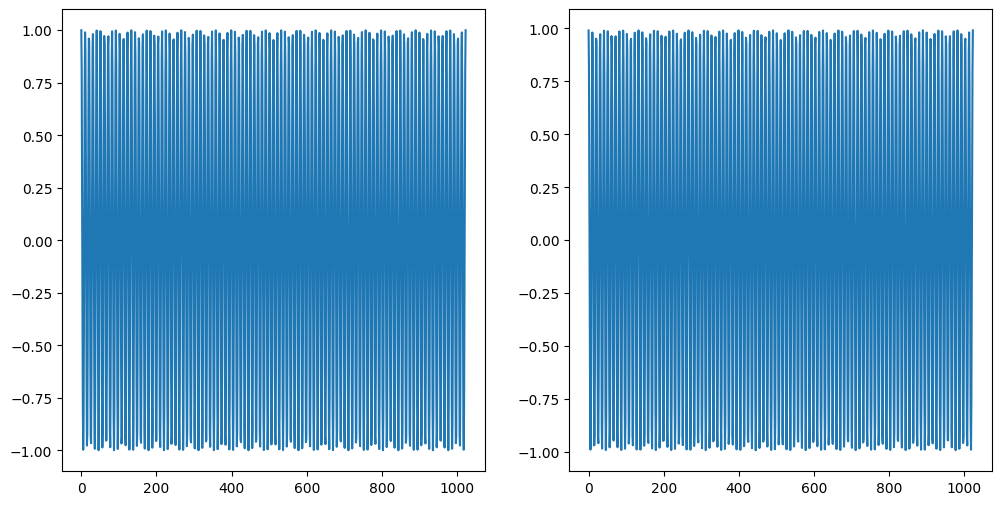

In [30]:
K_best_rbf = {'l': K_best_l}
best_P_rbf = functional_form_PDE(s_rbf, s_rbf, fx, kernel='rbf', **K_best_rbf)
print(mean_squared_error(fx, best_P_rbf))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(fx)
axs[1].plot(best_P_rbf)
plt.show()

In [26]:
# Polynomial
K_mse_poly = []
K_combinations_poly = []
for gamma in gamma_values:
    for c in c_values:
        for d in d_values:
            kwargs = {'coef0': c, 'degree': d, 'gamma': gamma}
            P_poly = functional_form_PDE(s_poly, s_poly, fx, kernel='poly', **kwargs)
            mse = mean_squared_error(fx, P_poly)
            K_mse_poly.append(mse)
            K_combinations_poly.append((c, d, gamma))

K_poly_data = pd.DataFrame(K_combinations_poly, columns=['c_value', 'd_value', 'gamma_value'])
K_poly_data['mse'] = K_mse_poly

K_poly_min_index = K_poly_data['mse'].idxmin()
K_best_c = K_poly_data.loc[K_poly_min_index, 'c_value']
K_best_d = U_poly_data.loc[K_poly_min_index, 'd_value']
K_best_gamma = K_poly_data.loc[K_poly_min_index, 'gamma_value']
print(f"Best coef0 value: {K_best_c}")
print(f"Best degree value: {K_best_d}")
print(f"Best gamma value: {K_best_gamma}")


d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=9.75181e-25): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), fx)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=9.05774e-40): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), fx)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=3.91023e-56): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), fx)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=3.57817e-69): result may not be accu

Best coef0 value: 0.5
Best degree value: 1
Best gamma value: 0.0001


d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=4.11451e-81): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), fx)


109233.94243390494


d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=2.3274e-24): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), fx)


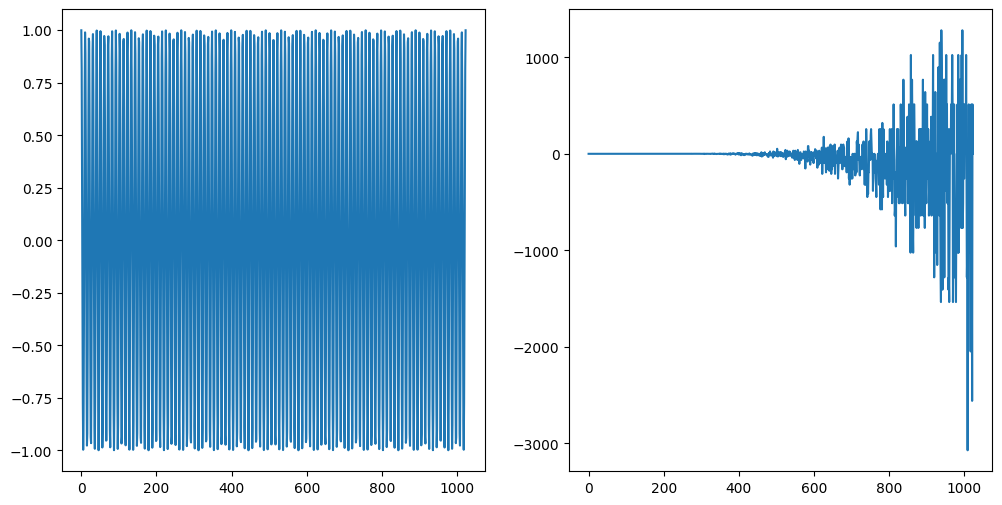

In [31]:
K_best_poly = {'coef0': K_best_c, 'degree': K_best_d, 'gamma': K_best_gamma}
best_P_poly = functional_form_PDE(s_poly, s_poly, fx, kernel='poly', **K_best_poly)
print(mean_squared_error(fx, best_P_poly))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(fx)
axs[1].plot(best_P_poly)
plt.show()

In [28]:
# Sigmoid
K_mse_sigmoid = []
K_combinations_sigmoid = []
for gamma in gamma_values:
    for c in c_values:
        kwargs = {'coef0': c, 'gamma': gamma}
        P_sigmoid = functional_form_PDE(s_sigmoid, s_sigmoid, fx, kernel='sigmoid', **kwargs)
        mse = mean_squared_error(fx, P_sigmoid)
        K_mse_sigmoid.append(mse)
        K_combinations_sigmoid.append((c, gamma))

K_sigmoid_data = pd.DataFrame(K_combinations_sigmoid, columns=['c_value', 'gamma_value'])
K_sigmoid_data['mse'] = K_mse_sigmoid

K_sigmoid_min_index = K_sigmoid_data['mse'].idxmin()
K_best_c_sigmoid = K_sigmoid_data.loc[K_sigmoid_min_index, 'c_value']
K_best_gamma_sigmoid = K_sigmoid_data.loc[K_sigmoid_min_index, 'c_value']
print(f"Best coef0 value: {K_best_c_sigmoid}")
print(f"Best gamma value: {K_best_gamma_sigmoid}")

Best coef0 value: 0.25
Best gamma value: 0.25


0.33790431517991953


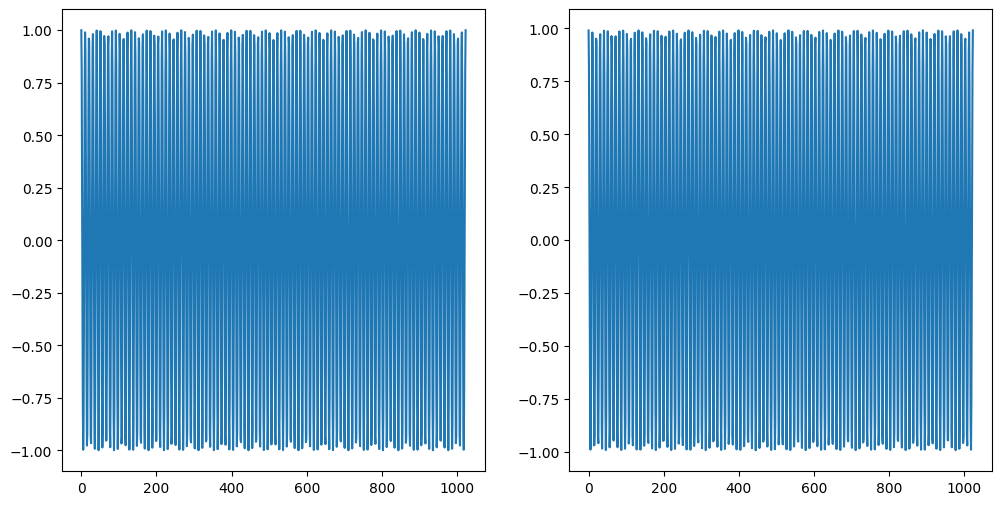

In [33]:
K_best_sigmoid = {'coef0': K_best_c_sigmoid, 'gamma': K_best_gamma_sigmoid}
best_P_sigmoid = functional_form_PDE(s_sigmoid, s_sigmoid, fx, kernel='sigmoid', **K_best_sigmoid)
print(mean_squared_error(fx, best_P_sigmoid))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(fx)
axs[1].plot(best_P_rbf)
plt.show()

In [34]:
print(U_rbf_data)
print(U_poly_data)
print(U_sigmoid_data)
print(K_rbf_data)
print(K_poly_data)
print(K_sigmoid_data)

   l_value       mse
0     0.01  0.000338
1     0.10  0.000251
2     1.00  0.000037
3     5.00  0.000364
4    10.00  0.000792
    c_value  d_value  gamma_value       mse
0      0.25        1       0.0001  0.000924
1      0.25        2       0.0001  0.000920
2      0.25        3       0.0001  0.000909
3      0.25        4       0.0001  0.000909
4      0.25        5       0.0001  0.000908
5      0.50        1       0.0001  0.000924
6      0.50        2       0.0001  0.000920
7      0.50        3       0.0001  0.000907
8      0.50        4       0.0001  0.000905
9      0.50        5       0.0001  0.000902
10     1.00        1       0.0001  0.000924
11     1.00        2       0.0001  0.000920
12     1.00        3       0.0001  0.000906
13     1.00        4       0.0001  0.000903
14     1.00        5       0.0001  0.000893
15     5.00        1       0.0001  0.000924
16     5.00        2       0.0001  0.000920
17     5.00        3       0.0001  0.000906
18     5.00        4       0.0001  0.0